In [45]:
import matplotlib.pyplot as plt
import numpy as np
from pymatgen.ext.matproj import MPRester
import plotly.graph_objects as go
import math

In [46]:
with MPRester("MykrkEqBZ7EQ2VUWndzndDME88749Z5b") as m: 
    prim_struc = m.get_structure_by_material_id("mp-961706")
    ph_dos = m.get_phonon_dos_by_material_id("mp-961706")

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

In [47]:
kb = 1.38064852e-23; h = 6.62607015e-34;t= np.arange(0.001,1000,5); R = 8.314 ; nat = len(prim_struc);freq = ph_dos.frequencies;densities = ph_dos.densities
cv_list = []
for temp in t:
    cv_list.append(ph_dos.cv(temp))
cv_list = np.array(cv_list) / (3 * nat * R)

Graphe de la chaleur spécifique molaire en fonction de la température

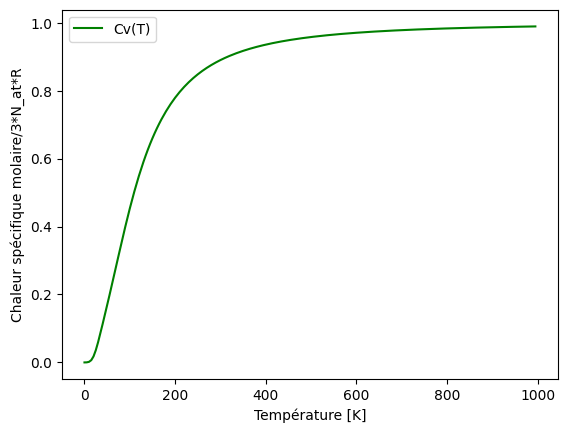

In [48]:
plt.plot(t, cv_list, color="green", label="Cv(T)")
plt.xlabel("Température [K]")
plt.ylabel("Chaleur spécifique molaire/3*N_at*R")
plt.legend()
plt.show()

Détermination des températures d'Einstein et de Debye.

In [49]:
# Modèle d'Einstein
def mod_einstein(ThetaE, T):
    cv = (ThetaE/T)**2 * np.exp(ThetaE/T) / (np.exp(ThetaE/T) - 1)**2
    if math.isnan(cv):
        cv= 0
    return cv

# Modèle de Debye
def mod_debye(ThetaD, T):
    x = np.linspace(0.00001, ThetaD/T, 50) 
    y = (x**4 * np.exp(x)) / (np.exp(x) - 1)**2
    integral =  np.trapz(y, x)
    cv = 3 * (T / ThetaD)**3 * integral
    if math.isnan(cv):  
        cv = 0
    return cv
    

def minima(start, end, step, T, Cv, f):
    def erreur_au_carré(Parameter):
        error = 0
        for i in range(len(T)):
            error += (Cv[i] - f(Parameter, T[i]))**2
        return error

    numbers = np.arange(start, end, step=step)
    result = [erreur_au_carré(num) for num in numbers]
    return numbers[np.argmin(result)]


tmp_Einstein = minima(300,370, 0.1, t, cv_list, mod_einstein) 
tmp_Debye = minima(400,500, 0.1, t,cv_list, mod_debye)  

/tmp/ipykernel_1689214/940850236.py:3: RuntimeWarning: overflow encountered in exp
  cv = (ThetaE/T)**2 * np.exp(ThetaE/T) / (np.exp(ThetaE/T) - 1)**2
/tmp/ipykernel_1689214/940850236.py:3: RuntimeWarning: invalid value encountered in scalar divide
  cv = (ThetaE/T)**2 * np.exp(ThetaE/T) / (np.exp(ThetaE/T) - 1)**2
/tmp/ipykernel_1689214/940850236.py:11: RuntimeWarning: overflow encountered in exp
  y = (x**4 * np.exp(x)) / (np.exp(x) - 1)**2
/tmp/ipykernel_1689214/940850236.py:11: RuntimeWarning: invalid value encountered in divide
  y = (x**4 * np.exp(x)) / (np.exp(x) - 1)**2


In [50]:
print(f"La température d'Einstein minimisant l'erreur au sens des moindres carrés est {tmp_Einstein} K")
print(f"La température de Debye minimisant l'erreur au sens des moindres carrés est {tmp_Debye} K")

La température d'Einstein minimisant l'erreur au sens des moindres carrés est 325.4000000000058 K
La température de Debye minimisant l'erreur au sens des moindres carrés est 440.30000000000916 K


Représentation des chaleurs spécifiques en fonction de la température pour les différents modèles.

/tmp/ipykernel_1689214/940850236.py:3: RuntimeWarning: overflow encountered in exp
  cv = (ThetaE/T)**2 * np.exp(ThetaE/T) / (np.exp(ThetaE/T) - 1)**2
/tmp/ipykernel_1689214/940850236.py:3: RuntimeWarning: invalid value encountered in scalar divide
  cv = (ThetaE/T)**2 * np.exp(ThetaE/T) / (np.exp(ThetaE/T) - 1)**2
/tmp/ipykernel_1689214/940850236.py:11: RuntimeWarning: overflow encountered in exp
  y = (x**4 * np.exp(x)) / (np.exp(x) - 1)**2
/tmp/ipykernel_1689214/940850236.py:11: RuntimeWarning: invalid value encountered in divide
  y = (x**4 * np.exp(x)) / (np.exp(x) - 1)**2


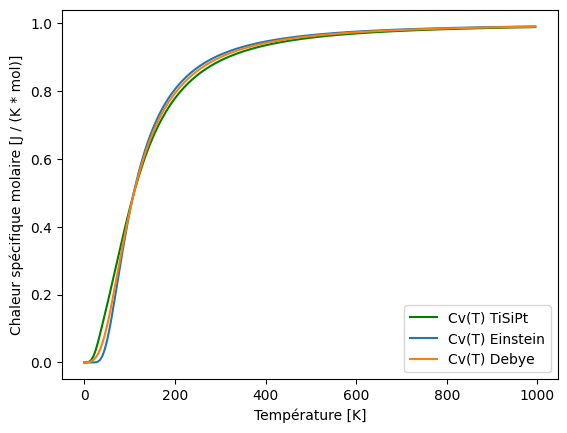

In [53]:
Cv_einstein = [];Cv_debye = []
for tmp in t:
    Cv_einstein.append(mod_einstein(tmp_Einstein, tmp));Cv_debye.append(mod_debye(tmp_Debye, tmp))

plt.plot(t, cv_list, color="green", label="Cv(T) TiSiPt")
plt.plot(t, Cv_einstein, label="Cv(T) Einstein")
plt.plot(t, Cv_debye, label="Cv(T) Debye")
plt.xlabel("Température [K]")
plt.ylabel("Chaleur spécifique molaire [J / (K * mol)]")
plt.legend()
plt.show()

Représentation des densités d'état de phonons correpondantes

Dans le modèle d'Einstein, la densité d'états correspond à un delta de Dirac situé en f_E.

Dans le modèle de Debye, la densité d'états est une fonction de la fréquence. Lorsqu'elle est exprimée en fonction de la fréquence, on a: g(w)=(9*N_at*f^2)/(2*PI*f_d^3) avec f_D la fréquence de Debye

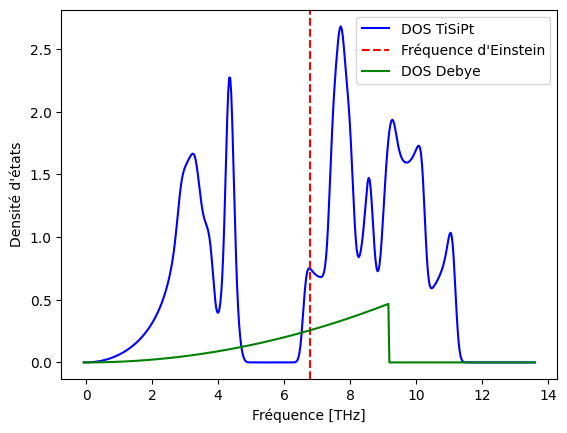

In [52]:
# Calcul de la fréquence de Einstein en THz
fE = tmp_Einstein * kb / h / 10**12

# Calcul de la fréquence de Debye en THz
fD = tmp_Debye * kb / h / 10**12

# Calcul de la densité d'états de Debye
gD = np.zeros_like(freq)
for i in range(len(freq)):
    if freq[i] < fD:
        gD[i] = 9 * nat * freq[i]**2 / (2 * np.pi * fD**3)

plt.plot(freq, densities, color="blue", label="DOS TiSiPt")
plt.axvline(x=fE, color='r', linestyle='--', label="Fréquence d'Einstein")
plt.plot(freq, gD, color="green", label="DOS Debye")
plt.legend()
plt.xlabel("Fréquence [THz]")
plt.ylabel("Densité d'états")
plt.show()